In [136]:
import pandas as pd
import numpy as np
import keras as K
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model,Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.models import Sequential
#moved to tensorflow=addons
from keras_contrib.layers import CRF
from pathlib import Path
#import tensorflow_addons as tfa
import tensorflow as tf

import os
import numpy as np

In [137]:
from tqdm import tqdm

#glove_path = Path.

embeddings_index = {}
with open(os.path.join(os.getcwd(), 'glove.6B.300d.txt'), encoding='utf8') as f:
    for i, line in tqdm(enumerate(f)):
        values = line.split()
        word = ''.join(values[:-300])
        coefs = np.asarray(values[-300:], dtype='float32')
        embeddings_index[word] = coefs

400000it [00:31, 12560.87it/s]


In [138]:
data_train = pd.read_csv('train2.csv')
data_test =  pd.read_csv('test2.csv')

In [139]:
print(data_train.tail())
print(data_test.tail())

       Sentence # Tag     Word
28641        2000   O    would
28642        2000   O  retrain
28643        2000   O      the
28644        2000   B    staff
28645        2000   O        .
      Sentence # Tag  Word
9864         676   O   was
9865         676   O  good
9866         676   O     ,
9867         676   O   too
9868         676   O     .


In [140]:
word_train = set(data_train['Word'].values)
word_test = set(data_test['Word'].values)
#or in-order to take a union of the two sets
words = list(word_train or word_test)

In [141]:
print(words)

['yuzu', 'unhurried', 'summer-eat', 'said', ')', 'absurdly', 'fusion', 'passive-aggressive', 'culinary', 'joya', 'horrific', 'preposterous', 'operation', '"well', "that's", 'yr', 'recent', 'complimented', 'charged', 'lasagna', 'grade', 'my', 'first', 'impeccable', 'fast', 'appropriate', '$25', 'low', 'going', 'gift', 'impecible', 'improved', 'ignore', 'sizes', 'budget', 'hipsters', 'waiting', 'person', 'hey', 'pot', 'talking', 'hideously', 'spotty', 'disapointing', 'gig', 'eating', 'shut-down', 'encrusted', 'instance', 'bf', 'bad:', 'arrived', 'rule', 'alked', 'rate', 'serves', 'hyde', 'silverware', 'roosevelt', 'shout', 'tasting', 'crust', 'it;', 'plans', 'friendliest', 'offensive', 'walked', 'breathtaking', 'hearing', 'chic', 'genuinely', 'hideous', 'ration', 'based', 'avoid', 'accept', 'threatened', 'wont', 'comes', 'per', '13', 'weekends', 'entrees', 'uppereast', 'waitstaffs', 'average', "couldn't", 'soon', 'wants', 'greeting', 'vinegar', 'deserves', 'values', 'kettle', 'outdoor', 

In [142]:
word_true = 0
for word in words:
    if word in embeddings_index:
        word_true += 1

In [143]:
print(len(words))
print(word_true)

3599
3142


In [144]:
word2idx = {}
#FOR PADDING SHORT SENTENCES
word2idx['<PAD>'] = 0
#REPLACE RARE OR UNKNOWN WORDS IN VOCABULARY 
word2idx['<UNK>'] = 1
#PLUS TWO FOR PADDING AND UNKNOWN WORD ALREADY INDEXED
for i, word in enumerate(words):
    word2idx[word] = i + 2

In [145]:
print(word2idx)

{'<PAD>': 0, '<UNK>': 1, 'yuzu': 2, 'unhurried': 3, 'summer-eat': 4, 'said': 5, ')': 6, 'absurdly': 7, 'fusion': 8, 'passive-aggressive': 9, 'culinary': 10, 'joya': 11, 'horrific': 12, 'preposterous': 13, 'operation': 14, '"well': 15, "that's": 16, 'yr': 17, 'recent': 18, 'complimented': 19, 'charged': 20, 'lasagna': 21, 'grade': 22, 'my': 23, 'first': 24, 'impeccable': 25, 'fast': 26, 'appropriate': 27, '$25': 28, 'low': 29, 'going': 30, 'gift': 31, 'impecible': 32, 'improved': 33, 'ignore': 34, 'sizes': 35, 'budget': 36, 'hipsters': 37, 'waiting': 38, 'person': 39, 'hey': 40, 'pot': 41, 'talking': 42, 'hideously': 43, 'spotty': 44, 'disapointing': 45, 'gig': 46, 'eating': 47, 'shut-down': 48, 'encrusted': 49, 'instance': 50, 'bf': 51, 'bad:': 52, 'arrived': 53, 'rule': 54, 'alked': 55, 'rate': 56, 'serves': 57, 'hyde': 58, 'silverware': 59, 'roosevelt': 60, 'shout': 61, 'tasting': 62, 'crust': 63, 'it;': 64, 'plans': 65, 'friendliest': 66, 'offensive': 67, 'walked': 68, 'breathtaking

In [146]:
print(word2idx['judging'])

3347


In [147]:
#SETING THE EMBEDDING DIMENSION TO 300
EMBEDDING_DIM = 300
#each word will be represented by a array of 300 values
#therefore we are declaring a len(words)+2 X 300 dimensions

embedding_matrix = np.zeros((len(words)+2, EMBEDDING_DIM))
"""
for all the words indexed in our dictionary we get the embedding value from
the glove embedding and save it in the embedding matrix as it's vector representation'
if the vector is not present we tag the word as the unknown/rare word since it is
not present in the embedding .

"""
for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is None:
        embedding_matrix[i] = embeddings_index['unk']
    else:
        embedding_matrix[i] = embedding_vector

# embedding_matrix[0] is all zeros for padding
embedding_matrix[0] = np.zeros(EMBEDDING_DIM)

In [148]:
embedding_matrix.shape

(3601, 300)

In [149]:
'unk' in embeddings_index

True

In [150]:
print(len(word2idx))

3601


In [151]:
data = data_train



# Save all words as a list
#maximum sentences feature length is 75
max_len = 75
n_words = len(word2idx)
# the possible values of tags is :  B I O
tags = list(set(data["Tag"].values))
n_tags = len(tags)
print(tags)

['B', 'I', 'O']


In [152]:
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx['<pad>'] = 0
n_tags = len(tag2idx) # Due to <pad>, here total tag number is from 17 to 18
print(tag2idx)

{'B': 1, 'I': 2, 'O': 3, '<pad>': 0}


In [153]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
#                                                            s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(data)
sentences = getter.sentences

In [154]:
print(sentences[0])

[('judging', 'O'), ('from', 'O'), ('previous', 'O'), ('posts', 'O'), ('this', 'O'), ('used', 'O'), ('to', 'O'), ('be', 'O'), ('a', 'B'), ('good', 'O'), ('place', 'B'), (',', 'O'), ('but', 'O'), ('not', 'O'), ('any', 'O'), ('longer', 'O'), ('.', 'O')]


In [155]:
X = [[word2idx[w[0]] for w in s] for s in sentences]
print(X)
X_train = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

# Word2idx for y
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=0)

# Get one-hot labels
y_train = [to_categorical(i, num_classes=n_tags) for i in y]

[[3347, 1479, 2074, 2516, 1832, 2799, 2371, 2648, 3401, 2579, 2379, 2012, 1557, 1826, 2688, 232, 1999], [703, 2012, 3186, 2022, 330, 456, 2425, 2012, 53, 2955, 1448, 2488, 2193, 2379, 246, 1506, 2488, 1528, 2193, 362, 286, 1727, 703, 2022, 2632, 2990, 2424, 1528, 2432, 2022, 3373, 1815, 1999], [2432, 118, 307, 2425, 2265, 2936, 2012, 1154, 3079, 2231, 3547, 1932, 2012, 1528, 1759, 156, 1017, 2990, 2193, 1099, 1999], [2193, 2931, 246, 1232, 2488, 3426, 809, 2451, 3426, 3299, 1528, 2193, 2346, 1096, 1999], [1141, 2368, 3106, 2012, 2432, 1974, 2371, 2039, 3357, 2193, 504, 100, 1999], [76, 1832, 2379, 1456], [649, 1287, 1546, 2955, 956, 2012, 3430, 287, 2012, 2193, 2931, 587, 2158, 1533, 2012, 872, 2579, 1999], [956, 587, 2193, 2355, 2789, 2990, 3240, 725, 1528, 463, 825, 1999], [2193, 1853, 2212, 587, 2158, 3217, 1528, 2193, 1348, 1006, 2991, 1252, 1400, 246, 2233, 456, 1832, 1283, 1999], [2193, 3104, 1098, 587, 3297, 1528, 3171, 3430, 2579, 94, 1999], [3547, 2193, 2149, 2012, 1744, 966, 

In [156]:
print(X[0])
print(len(X_train))
print(len(y_train))


[3347, 1479, 2074, 2516, 1832, 2799, 2371, 2648, 3401, 2579, 2379, 2012, 1557, 1826, 2688, 232, 1999]
2000
2000


In [157]:
n_words

3601

In [185]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, 
                  output_dim=300,
                  weights=[embedding_matrix],
                  input_length=max_len, 
                  mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=256, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM

model = TimeDistributed(Dense(50, activation="tanh"))(model) 

outputs =K.layers.Dense(n_tags, activation=tf.nn.softmax)(model)
model = Model(input,outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=10,
                    validation_split=0.1, verbose=1)



hist = pd.DataFrame(history.history)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 75)]              0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 75, 300)           1080300   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 75, 512)           1140736   
_________________________________________________________________
time_distributed_10 (TimeDis (None, 75, 50)            25650     
_________________________________________________________________
dense_20 (Dense)             (None, 75, 4)             204       
Total params: 2,246,890
Trainable params: 2,246,890
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
57/57 [==============================] - 111s 2s/step - loss: 0.0355 - accuracy: 0.8510 - val_loss:

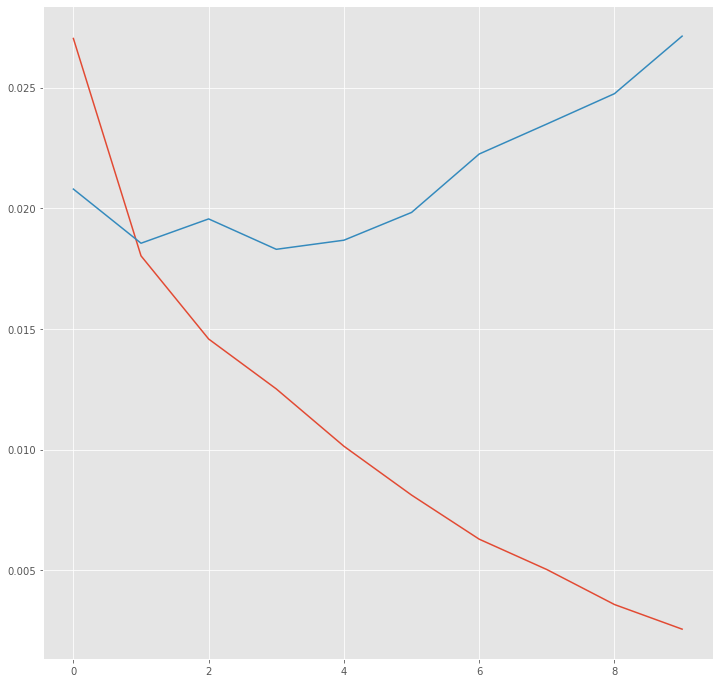

In [186]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()


In [187]:
data = data_test

# Sentence class
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
#                                                            s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(data)
sentences = getter.sentences # get all sentences
   
# Word2inx & Padding for X
X = [[word2idx.get(w[0], 1) for w in s] for s in sentences]
X_test = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

# Word2inx & Padding for y
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=0)

# Get one-hot labels
y_test = [to_categorical(i, num_classes=n_tags) for i in y]

In [188]:
print(sentences[1])
print(X_test[1])
print(np.argmax(y_test[1], -1))

[('serves', 'O'), ('really', 'O'), ('good', 'O'), ('sushi', 'B'), ('.', 'O')]
[  57 1875 2579 3237 1999    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
[3 3 3 1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]


In [189]:
idx2word = {value: key for key, value in word2idx.items()}
idx2tag = {value: key for key, value in tag2idx.items()}


true_all = np.argmax(y_test, -1)

true_all_tags = [[idx2tag[idx] for idx in s if idx!=0] for s in true_all]

p_all = model.predict(np.array(X_test)) # (4796, 75, 18)
p_all= np.argmax(p_all, axis=-1) # (4796, 75)
p_all_tags = [[idx2tag[idx] for idx in s] for s in p_all] # ['B-gpe', 'O', 'O', 'O']

for i, true in enumerate(true_all_tags):
    length = len(true)
    p_all_tags[i] = p_all_tags[i][:length]

p_all_tags = [[x.replace('<pad>', 'O') for x in s] for s in p_all_tags]

# for (true_tag, p)

print(sentences[3])
print(X_test[3])
print(true_all_tags[3])
print(p_all_tags[3])

[('green', 'B'), ('tea', 'I'), ('creme', 'I'), ('brulee', 'I'), ('is', 'O'), ('a', 'B'), ('must', 'O'), ('!', 'O')]
[2107 2066    1    1  587 3401  184 1456    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
['B', 'I', 'I', 'I', 'O', 'B', 'O', 'O']
['O', 'I', 'I', 'O', 'O', 'O', 'O', 'O']


In [182]:
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(sentences[3], true_all_tags[3], p_all_tags[3]):
    if w != 0:
        print("{:15}: {:5} {}".format(w[0], w[1], pred))

Word           ||True ||Pred
green          : B     I
tea            : I     I
creme          : I     I
brulee         : I     O
is             : O     O
a              : B     O
must           : O     O
!              : O     O


In [190]:
from seqeval.metrics import f1_score, classification_report
print(f1_score(true_all_tags, p_all_tags))
print(classification_report(true_all_tags, p_all_tags))  

0.5553113553113554
              precision    recall  f1-score   support

           _       0.60      0.52      0.56       735

   micro avg       0.60      0.52      0.56       735
   macro avg       0.60      0.52      0.56       735
weighted avg       0.60      0.52      0.56       735



In [191]:
print(sentences[7])
print(X_test[7])
print(true_all_tags[7])
print(p_all_tags[7])      

print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(sentences[7], true_all_tags[7], p_all_tags[7]):
    if w != 0:
        print("{:15}: {:5} {}".format(w[0], w[1], pred))

[('it', 'O'), ('has', 'O'), ('great', 'O'), ('sushi', 'B'), ('and', 'O'), ('even', 'O'), ('better', 'O'), ('service', 'B'), ('.', 'O')]
[1174 3171  860 3237 1528 2791 2113  694 1999    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
['O', 'O', 'O', 'B', 'O', 'O', 'O', 'B', 'O']
['O', 'O', 'O', 'B', 'O', 'O', 'O', 'B', 'O']
Word           ||True ||Pred
it             : O     O
has            : O     O
great          : O     O
sushi          : B     B
and            : O     O
even           : O     O
better         : O     O
service        : B     B
.              : O     O


In [175]:
print(outputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 75, 4), dtype=tf.float32, name=None), name='dense_16/Softmax:0', description="created by layer 'dense_16'")
